In [1]:
"""Improve name detector with both accuracy and inference time
"""

import argparse
import sys
import os

import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

# Make this script able to call lib module from parent level
sys.path.append(os.getcwd())
sys.path.append('../../line_detector/')

from lib.networks.factory import get_network
from lib.fast_rcnn.config import cfg,cfg_from_file
from lib.fast_rcnn.test import test_ctpn
from lib.text_connector.detectors import TextDetector
from lib.text_connector.text_connect_cfg import Config as TextLineCfg

import detector

DATA_DIR = os.path.join(os.path.expanduser('~'), 'Projects', 'FTI', 'Data', 'cropped')

In [2]:
# Config file
cfg_from_file('../../line_detector/text.yml')
config = tf.ConfigProto(allow_soft_placement=True)
config.gpu_options.allow_growth = True

sess = tf.InteractiveSession(config=config)

# Load pb graph
with tf.gfile.FastGFile('../../line_detector/models/ctpn.pb', 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())
    sess.graph.as_default()
    tf.import_graph_def(graph_def, name='')

sess.run(tf.global_variables_initializer())

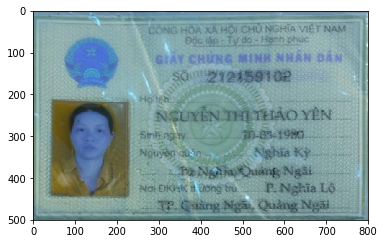

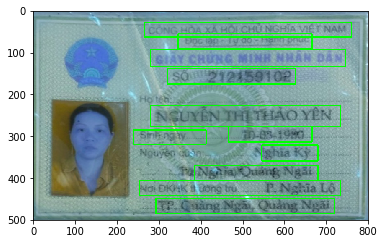

array([[[ 99, 133, 157],
        [ 99, 133, 157],
        [ 98, 132, 156],
        ..., 
        [103, 134, 159],
        [102, 133, 158],
        [ 99, 133, 157]],

       [[103, 137, 161],
        [102, 136, 160],
        [102, 136, 160],
        ..., 
        [105, 136, 161],
        [103, 134, 159],
        [101, 132, 157]],

       [[106, 140, 164],
        [106, 140, 164],
        [105, 139, 163],
        ..., 
        [109, 141, 164],
        [106, 138, 161],
        [104, 136, 159]],

       ..., 
       [[ 78, 115, 129],
        [ 78, 116, 128],
        [ 78, 116, 128],
        ..., 
        [103, 143, 171],
        [103, 143, 171],
        [104, 143, 171]],

       [[ 73, 109, 125],
        [ 74, 111, 125],
        [ 74, 112, 124],
        ..., 
        [102, 142, 170],
        [101, 141, 169],
        [102, 141, 169]],

       [[ 75, 111, 127],
        [ 76, 112, 128],
        [ 76, 113, 127],
        ..., 
        [101, 141, 170],
        [ 99, 139, 168],
        [ 99, 137,

In [3]:
# Random a picture
import random

img_path = os.path.join(DATA_DIR, 
                        random.choice(os.listdir(DATA_DIR)))
img = cv2.imread(img_path)
plt.imshow(img)
plt.show()


def draw_boxes(img, boxes, color=(0, 255, 0), title=None):
    """Draw boxes in image given coordinates
    """
    clone = np.copy(img)
    for box in boxes:
        cv2.rectangle(clone, box[0], box[1], color, 2)

    if title:
        plt.title(title)
        
    plt.imshow(clone)
    plt.show()
    
    return clone


# Detect lines and show result
boxes = detector.query_pb(sess, cfg, img)

draw_boxes(img, boxes)

In [4]:
# Constant form region for ID
ID_REGION = [(380, 100), (800, 180)]
BIRTHDAY_REGION = [(380, 250), (800, 320)]
FIRST_NAME_REGION = [(330,150), (800, 250)]
SECOND_NAME_REGION = [(200, 210), (800, 285)]
FIRST_ADDRESS_REGION = [(480, 370), (800, 460)]
SECOND_ADDRESS_REGION = [(0, 420), (800, 500)]

classes = [None, 'id', 'name1', 'name2', 'birthday', 'address1', 'address2']

In [5]:
from grpc.beta import implementations
from tensorflow_serving.apis import prediction_service_pb2

# Connect to Reader server
host, port = 'localhost:9000'.split(':')
channel = implementations.insecure_channel(host, int(port))
stub = prediction_service_pb2.beta_create_PredictionService_stub(channel)

id_coord = detector.extract_info(stub, img,
                                boxes, ID_REGION, margin=0)

In [6]:
# Check which box is id_box by comparing (x2, y2)
for box in boxes:
    if box[-1] == id_coord[-1]:
        print(box)

[(320, 138), (626, 176)]


[(380, 138), (626, 176)]


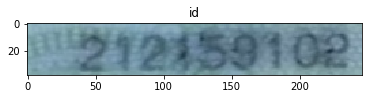

[(280, 227), (733, 277)]


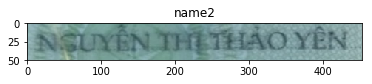

[(466, 277), (666, 314)]


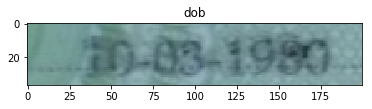

[(480, 405), (733, 442)]


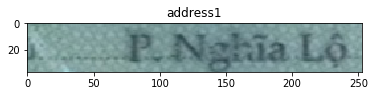

[(293, 448), (720, 484)]


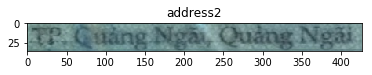

In [7]:
results = []
results.append(['id', detector.extract_info(stub, img, boxes, ID_REGION, margin=0)])
results.append(['name1', detector.extract_info(stub, img,
                                                boxes, FIRST_NAME_REGION, margin=0)])
results.append(['name2', detector.extract_info(stub, img,
                                                boxes, SECOND_NAME_REGION, margin=0)])
results.append(['dob', detector.extract_info(stub, img, boxes, BIRTHDAY_REGION, 
                                             h_threshold=20, margin=0)])
results.append(['address1', detector.extract_info(stub, img,
                                                  boxes, FIRST_ADDRESS_REGION, margin=0)])
results.append(['address2', detector.extract_info(stub, img,
                                                  boxes, SECOND_ADDRESS_REGION, margin=0)])

labels = [None] * len(boxes)
for (label, coord) in results:
    if coord is not None:
        print(coord)
        
        (x1, y1), (x2, y2) = coord
        
        plt.imshow(img[y1:y2, x1:x2])
        plt.title(label)
        plt.show()
        
        for i, box in enumerate(boxes):
            if coord[-1] == box[-1]:
                labels[i] = label

In [8]:
labels

['address1',
 None,
 'id',
 None,
 None,
 None,
 None,
 None,
 'name2',
 'dob',
 'address2']